<a href="https://colab.research.google.com/github/RVasconcelosMiguel/PerceptionMapping/blob/main/PMT3_versao_teste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = np.loadtxt('/content/data_slam.txt')

# Extract sections of the data
pose_data = data[:, :3]  # Pose variations: Δx, Δy, Δtheta
lidar_data = data[:, 3:]   # LIDAR measurements

# Parameters for LIDAR
angles = np.deg2rad(np.linspace(-30, 30, 61))  # Angles from -30° to 30°

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Função para converter medições LIDAR para coordenadas cartesianas
def lidar_to_cartesian(lidar_data, angles):
    x_coords = lidar_data * np.cos(angles)
    y_coords = lidar_data * np.sin(angles)
    return np.vstack((x_coords, y_coords)).T  # Transposta para (N, 2)

# Implementação do algoritmo Douglas-Peucker
def douglas_peucker(points, epsilon):
    """
    Simplifica uma linha poligonal usando o algoritmo Douglas-Peucker.
    :param points: Lista de pontos [(x1, y1), (x2, y2), ...].
    :param epsilon: Distância mínima para manter um ponto.
    :return: Pontos simplificados [(x1, y1), (xk, yk), ...].
    """
    # Encontrar a distância máxima de um ponto à linha inicial-final
    start, end = points[0], points[-1]
    line_vector = end - start
    line_length = np.linalg.norm(line_vector)

    if line_length == 0:
        distances = np.linalg.norm(points - start, axis=1)
    else:
        normalized_vector = line_vector / line_length
        projections = np.dot(points - start, normalized_vector)
        projections_points = start + np.outer(projections, normalized_vector)
        distances = np.linalg.norm(points - projections_points, axis=1)

    max_dist_idx = np.argmax(distances)
    max_dist = distances[max_dist_idx]

    # Dividir recursivamente se a distância máxima for maior que epsilon
    if max_dist > epsilon:
        left = douglas_peucker(points[:max_dist_idx + 1], epsilon)
        right = douglas_peucker(points[max_dist_idx:], epsilon)
        return np.vstack((left[:-1], right))
    else:
        return np.array([start, end])

# Função principal para detecção de cantos usando Douglas-Peucker
def detect_corners_douglas_peucker(lidar_data, angles, epsilon, radius=0.5):
    import numpy as np

    corners = []
    lidar_cartesian = lidar_to_cartesian(lidar_data, angles)  # Convert to Cartesian coordinates

    # Simplify the line using Douglas-Peucker
    simplified_points = douglas_peucker(lidar_cartesian, epsilon)

    # Detect indices of simplified points in the original data
    for point in simplified_points:
        idx = np.where((lidar_cartesian == point).all(axis=1))[0]
        if len(idx) > 0:
            corners.append(idx[0])

    # Filter out the first and last points
    corners = [idx for idx in corners if idx != 0 and idx != len(lidar_cartesian) - 1]

    # Perform filtering based on distance to adjacent points
    filtered_corners = []
    for corner_idx in corners:
        prev_idx = corner_idx - 1
        next_idx = corner_idx + 1

        if prev_idx >= 0 and next_idx < len(lidar_cartesian):
            prev_point = lidar_cartesian[prev_idx]
            next_point = lidar_cartesian[next_idx]
            corner_point = lidar_cartesian[corner_idx]

            # Calculate distances to the adjacent points
            dist_to_prev = np.linalg.norm(corner_point - prev_point)
            dist_to_next = np.linalg.norm(corner_point - next_point)

            # Keep the corner only if both adjacent points are within the radius
            if dist_to_prev <= radius and dist_to_next <= radius:
                filtered_corners.append(corner_idx)

    return filtered_corners



# Plotar medições LIDAR com os cantos detectados
def plot_lidar_with_corners(lidar_data, corners, angles):
    x_coords, y_coords = lidar_to_cartesian(lidar_data, angles).T
    corner_x, corner_y = x_coords[corners], y_coords[corners]

    plt.figure(figsize=(8, 6))
    plt.scatter(x_coords, y_coords, s=10, label="Medições LIDAR", color='b')
    plt.scatter(corner_x, corner_y, color='r', label="Cantos Detectados", zorder=5)
    plt.axis("equal")
    plt.title("Medições LIDAR com Detecção por Douglas-Peucker")
    plt.xlabel("X (metros)")
    plt.ylabel("Y (metros)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Parâmetros
epsilon = 0.4  # Tolerância para a simplificação

# Iterar sobre as leituras LIDAR
for i in range(len(lidar_data)):
    lidar_row = lidar_data[i]
    corners = detect_corners_douglas_peucker(lidar_row, angles, epsilon)
    #plot_lidar_with_corners(lidar_row, corners, angles)

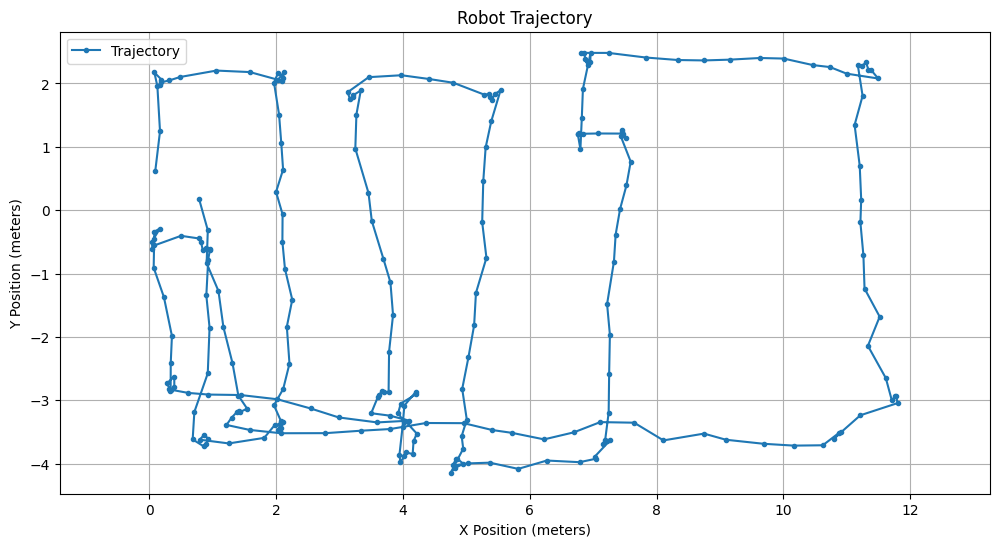

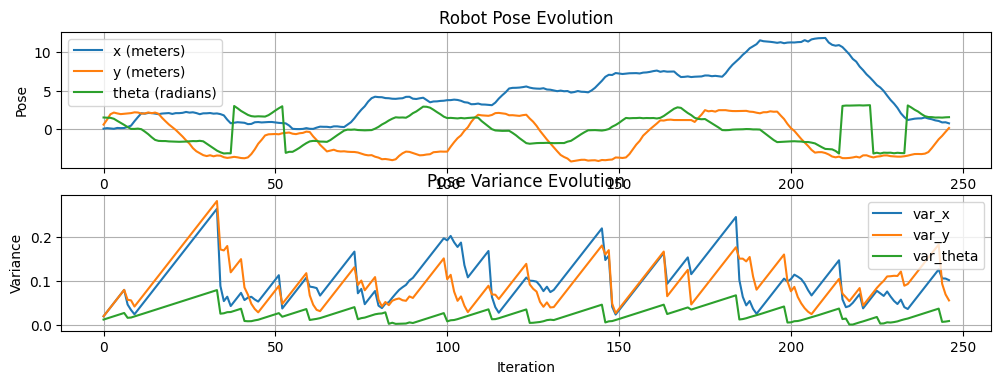

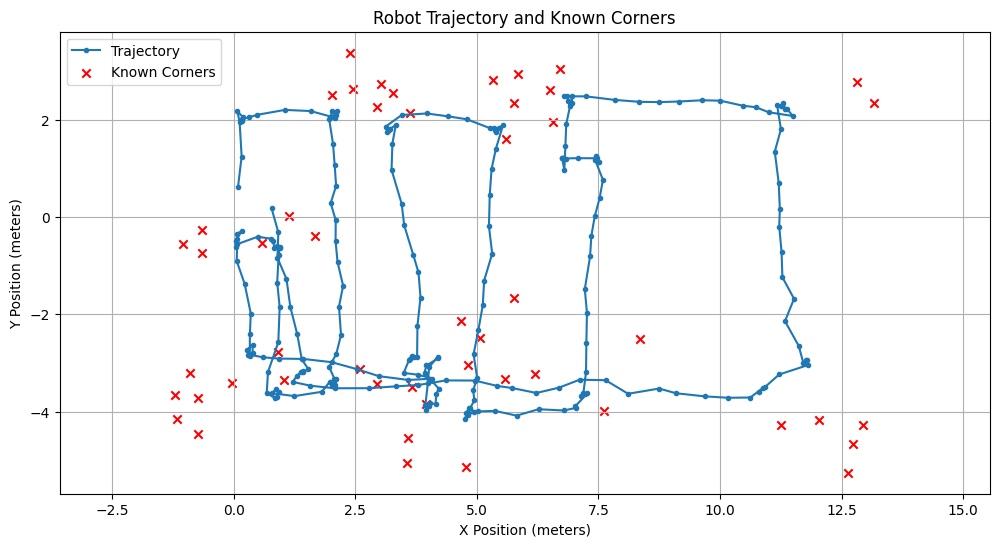

In [95]:
initial_pose = np.array([0.0, 0.0, np.pi / 2])  # Robô começa em (0, 0, pi/2)
P = np.diag([0.01, 0.01, 0.01])

cov_q=0.1  #Odometry

Q = np.diag([cov_q**2, cov_q**2, (cov_q/2)**2])

def update_pose(pose, delta_pose):
    x, y, theta = pose
    dx, dy, dtheta = delta_pose

    # Atualizar a pose
    new_x = x + dx
    new_y = y + dy
    new_theta = theta + dtheta

    return np.array([new_x, new_y, new_theta])

def lidar_to_global(pose, lidar_distances, angles):
    x_robot, y_robot, theta_robot = pose
    lidar_coords_global = []

    for distance, angle in zip(lidar_distances, angles):
        x_local = distance * np.cos(angle)
        y_local = distance * np.sin(angle)

        rotation_matrix = np.array([
            [np.cos(theta_robot), -np.sin(theta_robot)],
            [np.sin(theta_robot), np.cos(theta_robot)]
        ])

        lidar_local = np.array([x_local, y_local])
        lidar_global = rotation_matrix.dot(lidar_local)
        lidar_global += np.array([x_robot, y_robot])

        lidar_coords_global.append(lidar_global)

    return np.array(lidar_coords_global)


def is_known_corner(new_corner, known_corners, pose_covariance, base_threshold=0.1):
    """
    Verifies if a new corner is close to a known corner, using a dynamically scaled distance threshold.
    :param new_corner: Coordinates of the new corner (x, y).
    :param known_corners: List of known corners [(x1, y1), ...].
    :param pose_covariance: Covariance matrix (3x3) of the robot's pose.
    :param base_threshold: Base distance threshold.
    :return: Index of the known corner or -1 if no match is found.
    """
    # Extract position-related variances from pose covariance
    position_std = np.sqrt(pose_covariance[0, 0] + pose_covariance[1, 1])  # Combined std dev in x and y
    #dynamic_threshold = 8 * position_std  # Scale with a multiple of std dev
    dynamic_threshold = 0.4
    for i, known_corner in enumerate(known_corners):
        distance = np.linalg.norm(new_corner - known_corner)
        if distance < dynamic_threshold:
            return i
    return -1


def kalman_predict(state, P, delta_pose):
    x, y, theta = state
    dx, dy, dtheta = delta_pose
    predicted_state = np.array([
        x + dx ,
        y + dy ,
        normalize_angle(theta + dtheta)
    ])


    jacobian = np.eye(3)
    P = jacobian @ P @ jacobian.T + Q

    return predicted_state, P

# Função para processar leituras LIDAR e variações da pose
def kalman_update(pose, P, lidar_data, angles, known_corners, corner_covariances):
    """
    Updates the robot's pose and the map with landmarks using LIDAR data and the Kalman filter.
    :param pose: Current robot pose [x, y, θ].
    :param P: Current pose covariance matrix.
    :param lidar_data: LIDAR distance readings (array of distances).
    :param angles: Angles corresponding to the LIDAR readings.
    :param known_corners: List of known corners [(x, y), ...].
    :param corner_covariances: List of covariance matrices for known corners.
    :return: Updated pose, updated known corners, updated pose covariance, updated corner covariances.
    """
    # Convert LIDAR data to global coordinates
    lidar_coords_global = lidar_to_global(pose, lidar_data, angles)

    # Detect corners in LIDAR data
    corners_indices = detect_corners_douglas_peucker(lidar_data, angles, epsilon)
    detected_corners = lidar_coords_global[corners_indices]

    new_P = P
    new_pose = pose

    for corner in detected_corners:
        idx = is_known_corner(corner, known_corners, P)
        if idx == -1:  # New corner
            known_corners.append(corner)
            corner_covariances.append(np.eye(2) * 0.05)  # Initialize covariance for the new landmark
        else:
            # Calculate expected measurement for the known corner
            landmark = known_corners[idx]
            landmark_covariance = corner_covariances[idx]

            dist_p = np.sqrt((pose[0] - landmark[0])**2 + (pose[1] - landmark[1])**2)
            theta_p = normalize_angle(np.arctan2(landmark[1] - pose[1], landmark[0] - pose[0]) - pose[2])

            z = np.array([dist_p, theta_p])  # Expected measurement

            dist_p_e = np.sqrt((pose[0] - corner[0])**2 + (pose[1] - corner[1])**2)
            theta_p_e = normalize_angle(np.arctan2(corner[1] - pose[1], corner[0] - pose[0]) - pose[2])

            z_e = np.array([dist_p_e, theta_p_e])  # Observed measurement

            # Compute measurement Jacobian (H)
            H_pose = np.array([[-(landmark[0] - pose[0]) / dist_p, -(landmark[1] - pose[1]) / dist_p, 0],
                               [(landmark[1] - pose[1]) / dist_p**2, -(landmark[0] - pose[0]) / dist_p**2, -1]])
            H_landmark = np.array([[ (landmark[0] - pose[0]) / dist_p,  (landmark[1] - pose[1]) / dist_p],
                                   [-(landmark[1] - pose[1]) / dist_p**2,  (landmark[0] - pose[0]) / dist_p**2]])

            sdv_dist = 0.1
            sdv_ang = 0.02
            R = np.diag([(dist_p_e * sdv_dist)**2, sdv_ang**2])  # Measurement noise

            # Innovation covariance
            S = H_pose @ P @ H_pose.T + H_landmark @ landmark_covariance @ H_landmark.T + R

            # Kalman Gain
            K_pose = P @ H_pose.T @ np.linalg.inv(S)
            K_landmark = landmark_covariance @ H_landmark.T @ np.linalg.inv(S)

            # Measurement residual
            y = z - z_e
            y[1] = normalize_angle(y[1])

            # Update pose
            new_pose = new_pose + K_pose @ y
            new_pose[2] = normalize_angle(new_pose[2])

            # Update pose covariance
            new_P = (np.eye(len(pose)) - K_pose @ H_pose) @ P

            # Update landmark position
            updated_landmark = landmark + (K_landmark @ y)
            known_corners[idx] = updated_landmark

            # Update landmark covariance
            corner_covariances[idx] = (np.eye(2) - K_landmark @ H_landmark) @ landmark_covariance

    return new_pose, new_P, known_corners, corner_covariances


def normalize_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

# Simulação do sistema
robot_pose = initial_pose  # Pose inicial

poses = []           # To store [x, y, theta]
pose_variances = []  # To store [var_x, var_y, var_theta]
known_corners = []  # Mapa inicial de cantos
corner_covariances = []  # Covariâncias dos cantos

# Processar cada leitura do dataset
for i in range(len(lidar_data)):
    # Prediction step
    delta_pose = pose_data[i]
    lidar_row = lidar_data[i]

    robot_pose, P = kalman_predict(robot_pose, P, delta_pose)


    # Update step
    robot_pose, P, known_corners, corner_covariances = kalman_update(robot_pose, P, lidar_row, angles, known_corners, corner_covariances)

    poses.append(robot_pose)
    pose_variances.append(np.diag(P))  # Extract variances from P

# Visualizar o mapa e a trajetória
poses = np.array(poses)
pose_variances = np.array(pose_variances)


plt.figure(figsize=(12, 6))
plt.plot([pos[0] for pos in poses], [pos[1] for pos in poses], label="Trajectory", marker="o", markersize=3, linestyle="-")
plt.title("Robot Trajectory")
plt.xlabel("X Position (meters)")
plt.ylabel("Y Position (meters)")
plt.legend()
plt.grid()
plt.axis("equal")  # Equal axis scaling to represent the real geometry
plt.show()

# Continue with existing plots

# Plot robot pose (x, y, theta)
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(poses[:, 0], label="x (meters)")
plt.plot(poses[:, 1], label="y (meters)")
plt.plot(poses[:, 2], label="theta (radians)")
plt.title("Robot Pose Evolution")
plt.xlabel("Iteration")
plt.ylabel("Pose")
plt.legend()
plt.grid()

# Plot pose variances (diagonal elements of P)
plt.subplot(3, 1, 2)
plt.plot(pose_variances[:, 0], label="var_x")
plt.plot(pose_variances[:, 1], label="var_y")
plt.plot(pose_variances[:, 2], label="var_theta")
plt.title("Pose Variance Evolution")
plt.xlabel("Iteration")
plt.ylabel("Variance")
plt.legend()
plt.grid()

plt.figure(figsize=(12, 6))
plt.plot([pos[0] for pos in poses], [pos[1] for pos in poses], label="Trajectory", marker="o", markersize=3, linestyle="-")

# Plot the known corners (final ones)
known_corners_array = np.array(known_corners)
plt.scatter(known_corners_array[:, 0], known_corners_array[:, 1], c='r', marker='x', label="Known Corners")

# Titles and labels
plt.title("Robot Trajectory and Known Corners")
plt.xlabel("X Position (meters)")
plt.ylabel("Y Position (meters)")
plt.legend()
plt.grid()
plt.axis("equal")  # Equal axis scaling to represent the real geometry
plt.show()



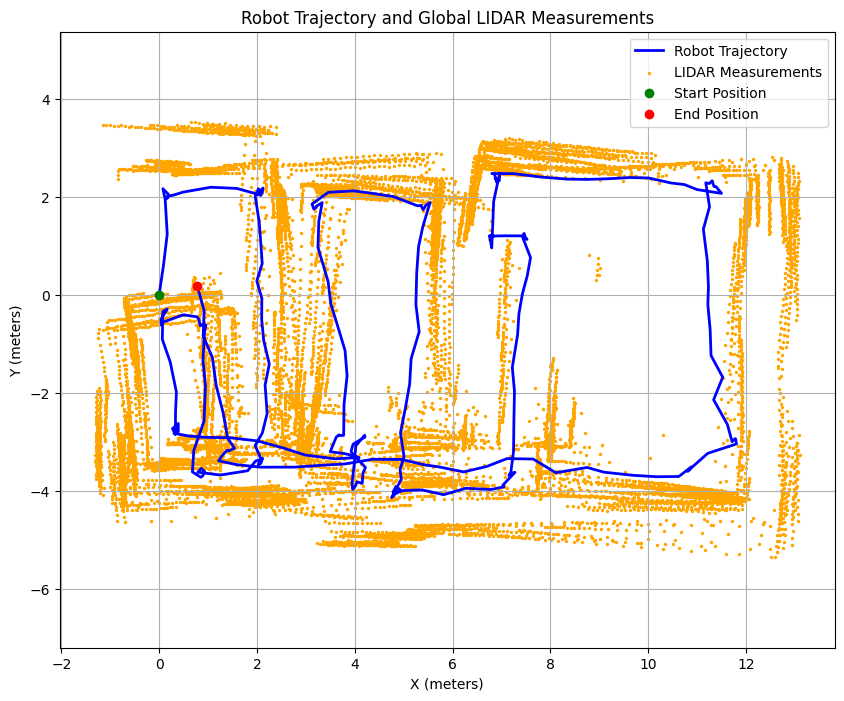

In [96]:
# Função para converter medições LIDAR para coordenadas globais
def lidar_to_global(pose, lidar_distances, angles):
    x_robot, y_robot, theta_robot = pose
    lidar_coords_global = []

    for distance, angle in zip(lidar_distances, angles):
        x_local = distance * np.cos(angle)
        y_local = distance * np.sin(angle)

        rotation_matrix = np.array([
            [np.cos(theta_robot), -np.sin(theta_robot)],
            [np.sin(theta_robot), np.cos(theta_robot)]
        ])

        lidar_local = np.array([x_local, y_local])
        lidar_global = rotation_matrix.dot(lidar_local)
        lidar_global += np.array([x_robot, y_robot])

        lidar_coords_global.append(lidar_global)

    return np.array(lidar_coords_global)

# Inicializar a pose do robô e listas para armazenar a trajetória e medições LIDAR globais
pose = initial_pose
trajectory = [pose]
lidar_global_data = []

# Calcular a trajetória e medições LIDAR globais

for i in range(len(poses)):
    pose = poses[i] # Get the pose from the poses array
    lidar_distances = lidar_data[i] # Get the corresponding lidar data

    trajectory.append(pose)

    lidar_global = lidar_to_global(pose, lidar_distances, angles)
    lidar_global_data.append(lidar_global)

# Converter listas para arrays
trajectory = np.array(trajectory)
lidar_global_data = np.vstack(lidar_global_data)  # Combinar todas as medições LIDAR

# Plotar a trajetória do robô e todas as medições LIDAR globais
plt.figure(figsize=(10, 8))

# Trajetória do robô
plt.plot(trajectory[:, 0], trajectory[:, 1], color='blue', label="Robot Trajectory", linewidth=2)

# Medições LIDAR globais
plt.scatter(lidar_global_data[:, 0], lidar_global_data[:, 1], color='orange', s=2, label="LIDAR Measurements")

# Marcar a posição inicial e final do robô
plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', label="Start Position", zorder=5)
plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='red', label="End Position", zorder=5)

# Configurações do gráfico
plt.axis("equal")
plt.title("Robot Trajectory and Global LIDAR Measurements")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.legend()
plt.grid(True)
plt.show()